In [280]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import os
import sys
from ipywidgets import widgets
from IPython.display import display, HTML
from IPython.display import clear_output
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import numpy as np


# Customized modules
HOME = '/home/serinatan/project/GPU-Virtualization-Benchmarks/util'
if HOME not in sys.path:
    sys.path.append(HOME)

import data.scripts.common.format as fmt
import data.scripts.common.constants as const
import data.scripts.gen_graphs.gen_altair_timeline as gen_altair
import data.scripts.common.help_iso as hi
import data.scripts.gen_tables.gen_lut_configs as gen_lut
import data.scripts.predict.allocation_design as alloc

SCRIPT_PATH = os.path.join(HOME, 'data/scripts') 
PKL_PATH = os.path.join(HOME, 'data/pickles') 
CSV_PATH = os.path.join(HOME, 'data/csv')
TIME_PATH = os.path.join(HOME, 'data/timeline')

%config InlineBackend.figure_format ='retina'
plt.style.use('seaborn-talk')

pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
def draw_table(df, cols, hide_index=True):
    if hide_index:
        return df[cols].style.set_table_styles(fmt.table_style).hide_index()
    else:
        return df[cols].style.set_table_styles(fmt.table_style)

# Timeline (1D v.s. 3D) for synthetic workloads

In [246]:
df_dynamic = pd.read_pickle(os.path.join(PKL_PATH, 'pair_dynamic.pkl'))
df_intra = pd.read_pickle(os.path.join(PKL_PATH, 'intra.pkl'))

In [298]:
pair_str_list = [dir for dir in os.listdir(TIME_PATH) if os.path.isdir(os.path.join(TIME_PATH, dir))]
# Only check synthetic workloads
pair_str_list = [p for p in pair_str_list if p.startswith('syn')]

pair_str_dd = widgets.Dropdown(options=pair_str_list, value='syn-0-syn-9', description="Pair_str:")
button = widgets.Button(description='Draw', button_style='info')
timeline_out = widgets.Output()

width = 1000

def onclick(b):
    timeline_out.clear_output()
    apps = const.split_pair_str(pair_str_dd.value)
    headers = [const.syn_yaml[app] for app in apps]

    with timeline_out:
        graphs = {}
        sld_dict = {}
        ws_best_ctx = 0
        config_best_ctx = 0
        # Iterate over all files (configs) inside this pair_str folder
        pair_path = os.path.join(TIME_PATH, pair_str_dd.value)
        for filename in os.listdir(pair_path):            
            graph, sld = gen_altair.draw_timeline_from_console(pair_str_dd.value, os.path.basename(filename), width=width)
            if graph:
                if "LUT" in filename:
                    graphs['LUT'] = graph
                    sld_dict['LUT'] = sld
                else:
                    if sum(sld) > ws_best_ctx:
                        ws_best_ctx = sum(sld)
                        config_best_ctx = hi.check_config('1_ctx', os.path.basename(filename), 0)
                        graphs['CTX'] = graph
                        sld_dict['CTX'] = sld
                        

        graphs['CTX'].display()
        print('slowdown: ', sld_dict['CTX'])
        print('ws:', sum(sld_dict['CTX']))
        
        quota, configs = gen_lut.get_config_matrix_from_ctx(apps, config_best_ctx)
        print('stream 1:', quota[0])
        print('stream 2:', quota[1])
        
        interference = gen_lut.get_interference_matrix(apps, configs, df_dynamic, df_intra)
        gen_lut.pretty_print_matrix(apps, 'Interference', interference, headers)
        
        gen_lut.predict_app(apps, interference)
        
#         print('\n')
#         print('Multi-Iteration')
#         gen_lut.predict_app(apps, interference, at_least_one=False, upper_lim=[1000, 1000])
        
        graphs['LUT'].display()
        print('slowdown: ', sld_dict['LUT'])
        print('ws:', sum(sld_dict['LUT']))
        configs, interference, serial_matrix = gen_lut.get_lut_matrix(apps, df_dynamic, df_intra)
        
        gen_lut.pretty_print_matrix(apps, 'Configs', configs, headers)
        gen_lut.predict_app(apps, interference)
        
#         print('Multi-Iteration')
#         gen_lut.predict_app(apps, interference, at_least_one=False, upper_lim=[1000, 1000])

button.on_click(onclick)
widgets.VBox([pair_str_dd, button, timeline_out])

In [326]:
lut_ctx = []
for pair in pair_str_list:
    entry = {'pair': pair, 'ws_3D': 0, 'ws_1D': 0, 'ctx_1D': 0}
    pair_path = os.path.join(TIME_PATH, pair)
    apps = const.split_pair_str(pair)
    
    for filename in os.listdir(pair_path):
        config_str = os.path.basename(filename).replace('.txt', '')
        data, sld = gen_altair.prepare_gpusim_console(pair, filename, config_str)
        
        if hi.check_config('lut', config_str, default=False):
            entry['ws_3D'] = sum(sld)
        else:
            # CTX config, only store max ws
            if entry['ws_1D'] < sum(sld):
                entry['ws_1D'] = sum(sld)
                entry['ctx_1D'] = hi.check_config('1_ctx', config_str, default=0)
        
    lut_ctx.append(entry)
                
df_lut_ctx = pd.DataFrame(lut_ctx)
            

syn-1-syn-8, V100-PAE-CONCURRENT-SEP_RW-LSRR-PRINT_DEVICE_SYNC-INTRA_0:0.5:0.5_RATIO-NUM_0:5:5_KERNEL-CAP_7368877_CYCLE simulation hit max cycles (7368877).
syn-1-syn-8, V100-PAE-CONCURRENT-SEP_RW-LSRR-PRINT_DEVICE_SYNC-INTRA_0:0.5078125:0.4921875_RATIO-NUM_0:5:5_KERNEL-CAP_7368877_CYCLE simulation hit max cycles (7368877).
syn-1-syn-8, V100-PAE-CONCURRENT-SEP_RW-LSRR-PRINT_DEVICE_SYNC-INTRA_LUT-NUM_0:5:5_KERNEL-CAP_7368877_CYCLE simulation hit max cycles (7368877).
syn-1-syn-8, V100-PAE-CONCURRENT-SEP_RW-LSRR-PRINT_DEVICE_SYNC-INTRA_0:0.51171875:0.48828125_RATIO-NUM_0:5:5_KERNEL-CAP_7368877_CYCLE simulation hit max cycles (7368877).
syn-1-syn-8, V100-PAE-CONCURRENT-SEP_RW-LSRR-PRINT_DEVICE_SYNC-INTRA_0:0.484375:0.515625_RATIO-NUM_0:5:5_KERNEL-CAP_7368877_CYCLE simulation hit max cycles (7368877).
syn-1-syn-8, V100-PAE-CONCURRENT-SEP_RW-LSRR-PRINT_DEVICE_SYNC-INTRA_0:0.515625:0.484375_RATIO-NUM_0:5:5_KERNEL-CAP_7368877_CYCLE simulation hit max cycles (7368877).
syn-3-syn-8, V100-PAE-CO

In [327]:
df_lut_ctx

,ctx_1D,pair,ws_1D,ws_3D
0,0.000000,syn-1-syn-7,0.000000,1.188302
1,0.484375,syn-0-syn-3,1.382109,1.404029
2,0.500000,syn-3-syn-6,1.512331,1.537725
3,0.484375,syn-1-syn-9,1.539957,1.599929
4,0.000000,syn-3-syn-7,0.000000,1.284486
5,0.000000,syn-6-syn-7,0.000000,2.002223
6,0.484375,syn-0-syn-4,1.444242,1.555285
7,0.500000,syn-6-syn-8,1.385404,1.376894
8,0.511719,syn-1-syn-8,1.046542,1.009978
9,0.000000,syn-1-syn-4,0.000000,1.446688


In [328]:
# Drop pairs that do not have both ctx and lut
df_lut_ctx = df_lut_ctx[(df_lut_ctx != 0).all(1)]

geomean = {'pair': 'geomean', 
           'ws_3D': scipy.stats.mstats.gmean(df_lut_ctx['ws_3D']),
           'ws_1D': scipy.stats.mstats.gmean(df_lut_ctx['ws_1D']),
          }
df_lut_ctx = df_lut_ctx.append(geomean, ignore_index=True)

print(geomean)

{'pair': 'geomean', 'ws_3D': 1.3807081734262272, 'ws_1D': 1.3652835048649263}


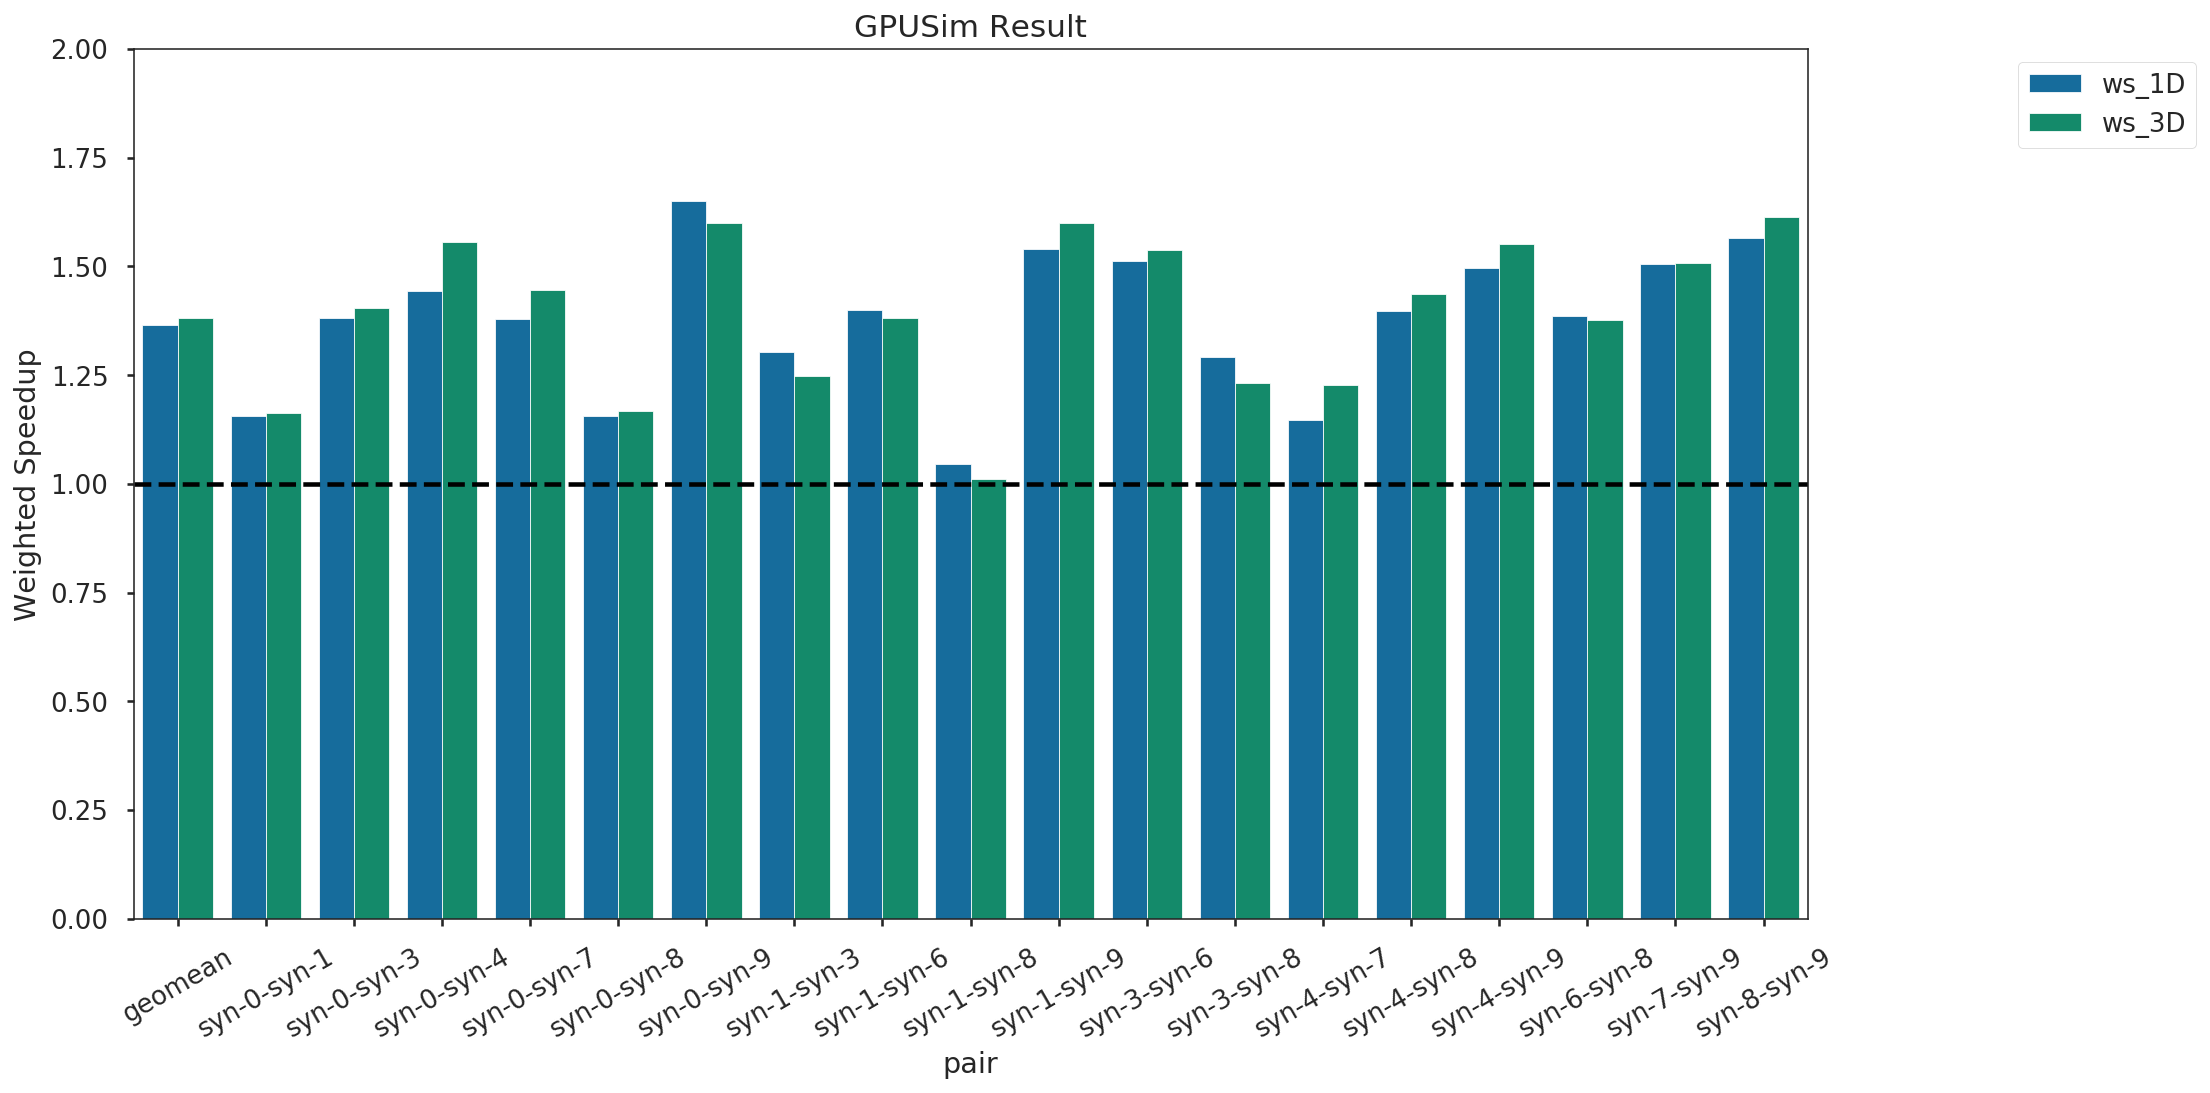

In [332]:
df_lut_ctx_long = pd.melt(df_lut_ctx, id_vars=['pair'], 
                          value_vars=['ws_1D', 'ws_3D'], 
                          var_name='Allocation Type').sort_values(['pair']).reset_index(drop=True)


plt.figure(figsize=(15,8))
ax = sns.barplot(x='pair', y='value', hue='Allocation Type', data=df_lut_ctx_long, hue_order=['ws_1D', 'ws_3D',])
plt.xticks(rotation=30)
plt.ylabel('Weighted Speedup')
plt.ylim([0, 2])

ax.legend(bbox_to_anchor=(1.24, 1))
ax.axhline(1.0, ls='--', color="black")
plt.title('GPUSim Result')

plt.show()

# Synthetic workloads characteristics

In [123]:
# kernel runtime distribution within each synthetic workloads
seq_cycles = [np.array(const.get_seq_cycles(syn)) / 1e6 for syn in const.syn_yaml]

print(seq_cycles)

[array([0.060681, 1.44265 , 0.018482, 0.027979, 0.097339]), array([1.280717, 0.012553, 0.097339, 1.44265 , 0.114292]), array([0.072729, 1.280717, 2.704051, 0.802931, 0.097339]), array([0.802931, 0.018482, 0.754938, 0.04309 , 1.280717]), array([0.132103, 0.123536, 0.114292, 0.097339, 0.027979]), array([4.706867, 0.058264, 0.027979, 0.04309 , 2.704051]), array([0.018482, 1.280717, 0.132103, 0.754938, 4.706867]), array([0.027979, 0.058264, 0.132103, 0.775995, 1.280717]), array([1.280717, 0.114292, 0.058264, 0.04309 , 1.44265 ]), array([0.04309 , 0.802931, 0.114292, 0.012553, 0.123536])]


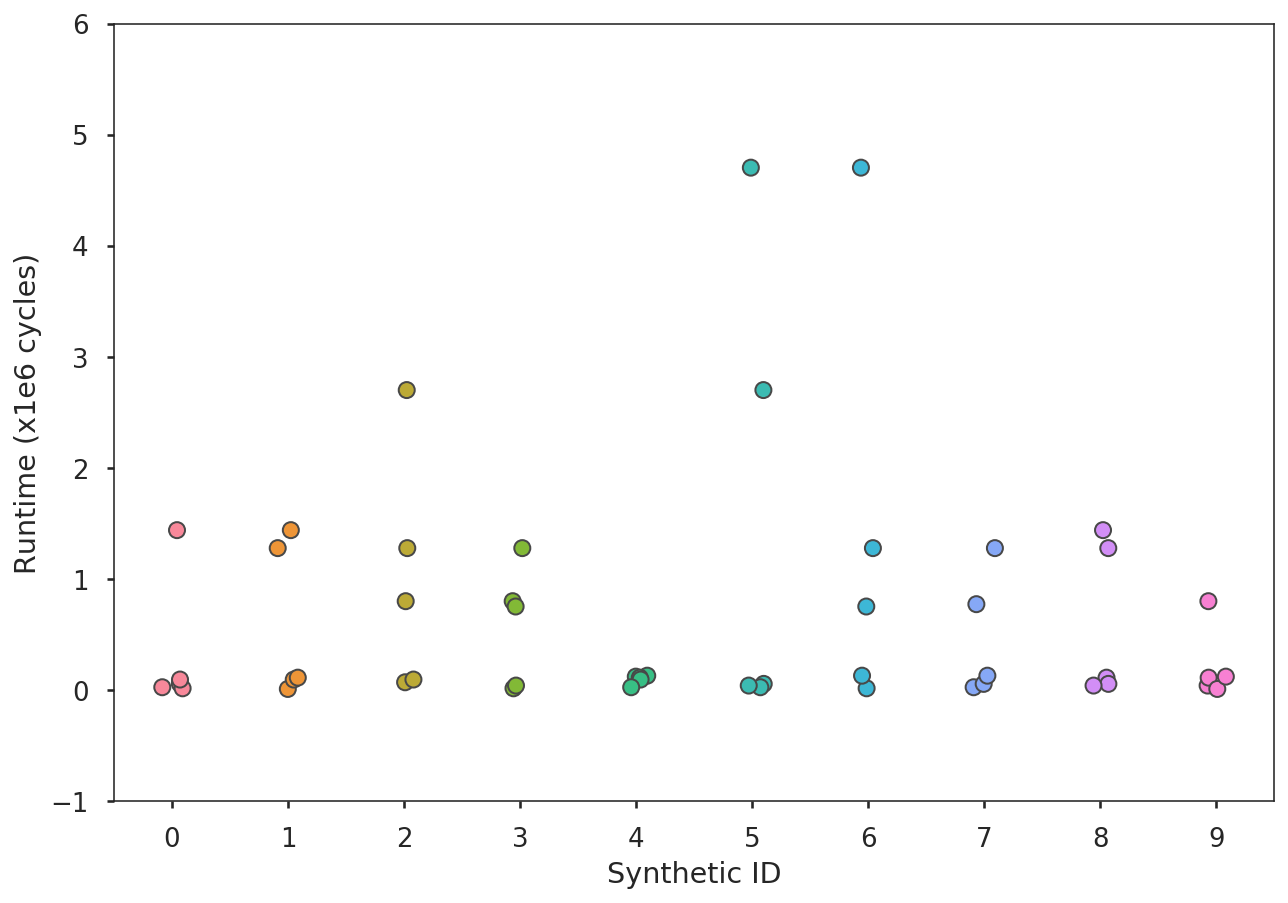

In [134]:
sns.stripplot(data=seq_cycles, size=8, linewidth=1)
plt.xlabel('Synthetic ID')
plt.ylabel('Runtime (x1e6 cycles)')
plt.ylim([-1, 6])

plt.show()

In [210]:
hello = [2]
print(hello*2)

[2, 2]


In [244]:
binom_list = [dir for dir in os.listdir(TIME_PATH) if os.path.isdir(os.path.join(TIME_PATH, dir))]

# Only check synthetic workloads
binom_list = [p for p in binom_list if p.startswith('nvd_binomial')]
print(binom_list)

['nvd_binomial-0-rod_heartwall-0', 'nvd_binomial-0-parb_stencil-0', 'nvd_binomial-0-nvd_sobol-0', 'nvd_binomial-0-rod_streamcluster-0', 'nvd_binomial-0-parb_cutcp-0', 'nvd_binomial-0-rod_hotspot3d-0']


In [245]:
for pair in binom_list:
    entry = {'pair': pair, 'ws_3D': 0}
    pair_path = os.path.join(TIME_PATH, pair)
    apps = const.split_pair_str(pair)
    
    for filename in os.listdir(pair_path):
        config_str = os.path.basename(filename).replace('.txt', '')
        data, sld = gen_altair.prepare_gpusim_console(pair, filename, config_str)
        
        print(pair, sld, sum(sld))

nvd_binomial-0-rod_heartwall-0 [0.9816289467757268, 0.962748299021595] 1.9443772457973219
nvd_binomial-0-parb_stencil-0 [0.9960507328928382, 0.5199308132088676] 1.5159815461017057
nvd_binomial-0-parb_stencil-0 [0.940368886119317, 0.5937441101301991] 1.5341129962495161
nvd_binomial-0-parb_stencil-0 [0.856551327768852, 0.5624886171690587] 1.4190399449379107
nvd_binomial-0-nvd_sobol-0 [0.6684623304459999, 0.8054930531051828] 1.4739553835511827
nvd_binomial-0-rod_streamcluster-0 [0.9498235849100082, 0.5381519106448971] 1.4879754955549052
nvd_binomial-0-parb_cutcp-0 [0.914287706089442, 0.8274687585665319] 1.7417564646559738
nvd_binomial-0-rod_hotspot3d-0 [0.8800053679320956, 0.7737451354940976] 1.6537505034261932


# Compare 1D and 3D based on prediction

In [279]:
syn_pairs = [[left, right] for left in const.syn_yaml for right in const.syn_yaml if left < right]

In [353]:
df_predict = alloc.build_df_predict(syn_pairs, at_least_one=True, upper_limit=[1600, 1600])

print(df_predict[df_predict['pair']=='geomean'][['pair', '1d', '3d']])

No feasible ctx config for ['syn-0', 'syn-2']
No feasible ctx config for ['syn-0', 'syn-5']
No feasible ctx config for ['syn-1', 'syn-2']
No feasible ctx config for ['syn-1', 'syn-5']
No feasible ctx config for ['syn-2', 'syn-3']
No feasible ctx config for ['syn-2', 'syn-4']
No feasible ctx config for ['syn-2', 'syn-5']
No feasible ctx config for ['syn-2', 'syn-6']
No feasible ctx config for ['syn-2', 'syn-7']
No feasible ctx config for ['syn-2', 'syn-8']
No feasible ctx config for ['syn-3', 'syn-5']
No feasible ctx config for ['syn-4', 'syn-5']
No feasible ctx config for ['syn-5', 'syn-6']
No feasible ctx config for ['syn-5', 'syn-7']
No feasible ctx config for ['syn-5', 'syn-8']
       pair        1d        3d
30  geomean  1.305389  1.377315


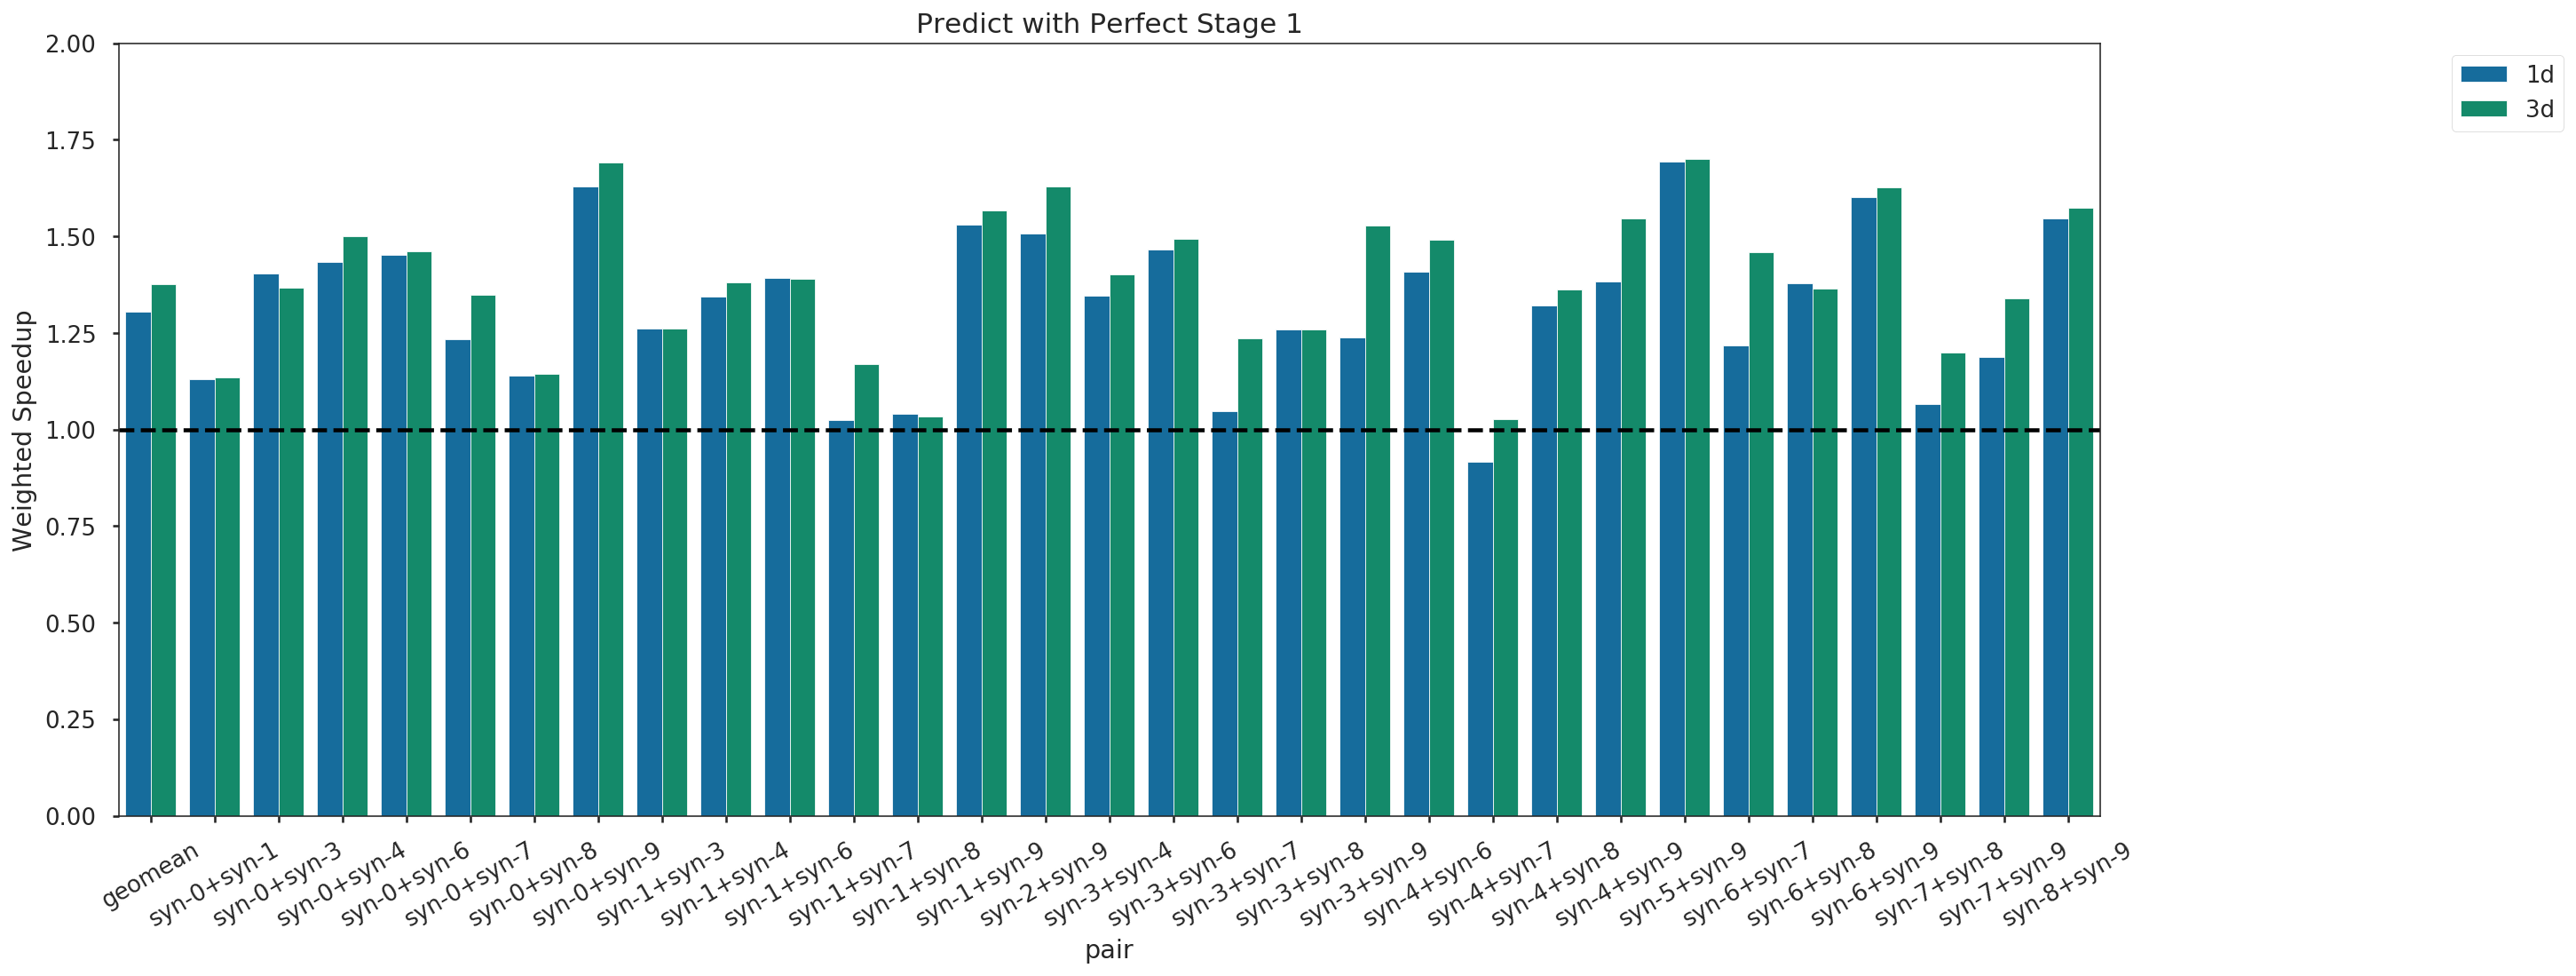

       pair        1d        3d
30  geomean  1.305389  1.377315


In [342]:
df_predict_long = pd.melt(df_predict, id_vars=['pair'], 
                          value_vars=['1d', '3d'], 
                          var_name='Allocation Type').sort_values(['pair']).reset_index(drop=True)


plt.figure(figsize=(20,8))
ax = sns.barplot(x='pair', y='value', hue='Allocation Type', data=df_predict_long, hue_order=['1d', '3d'])
plt.xticks(rotation=30)
plt.ylabel('Weighted Speedup')
plt.ylim([0, 2])

ax.legend(bbox_to_anchor=(1.24, 1))
ax.axhline(1.0, ls='--', color="black")
plt.title('Predict with Perfect Stage 1')

plt.show()

print(df_predict[df_predict['pair']=='geomean'][['pair', '1d', '3d']])

In [356]:
predict_dd = widgets.Dropdown(options=df_predict['pair'], description="Pair_str:")
predict_button = widgets.Button(description='Draw', button_style='info')
predict_out = widgets.Output()

width = 1000

def onclick(b):
    predict_out.clear_output()
    apps = predict_dd.value.split('+')
    headers = [const.syn_yaml[app] for app in apps]
    series_app = df_predict[df_predict['pair'] == predict_dd.value].iloc[0]

    with predict_out:
        # Draw timeline for 1D
        graph = gen_altair.draw_timeline_from_prediction(series_app['1d_time_stamps'], apps, series_app['1d_norm_ipc'], "1D Prediction", xmax=8000000)
        graph.display()

        # Draw timeline for 3D
        graph = gen_altair.draw_timeline_from_prediction(series_app['3d_time_stamps'], apps, series_app['3d_norm_ipc'], "3D Prediction", xmax=8000000)
        graph.display()


predict_button.on_click(onclick)
widgets.VBox([predict_dd, predict_button, predict_out])

In [351]:
df_predict[['pair', 'ctx', '1d', '3d']]

,pair,ctx,1d,3d
0,syn-0+syn-1,0.500000,1.111888,1.114526
1,syn-0+syn-3,0.500000,1.339411,1.358870
2,syn-0+syn-4,0.484375,1.438491,1.491236
3,syn-0+syn-6,0.500000,1.458244,1.440840
4,syn-0+syn-7,0.500000,1.180870,1.324955
5,syn-0+syn-8,0.500000,1.117243,1.119885
6,syn-0+syn-9,0.484375,1.637815,1.703931
7,syn-1+syn-3,0.484375,1.262661,1.280207
8,syn-1+syn-4,0.484375,1.336646,1.387317
9,syn-1+syn-6,0.500000,1.382223,1.378923
